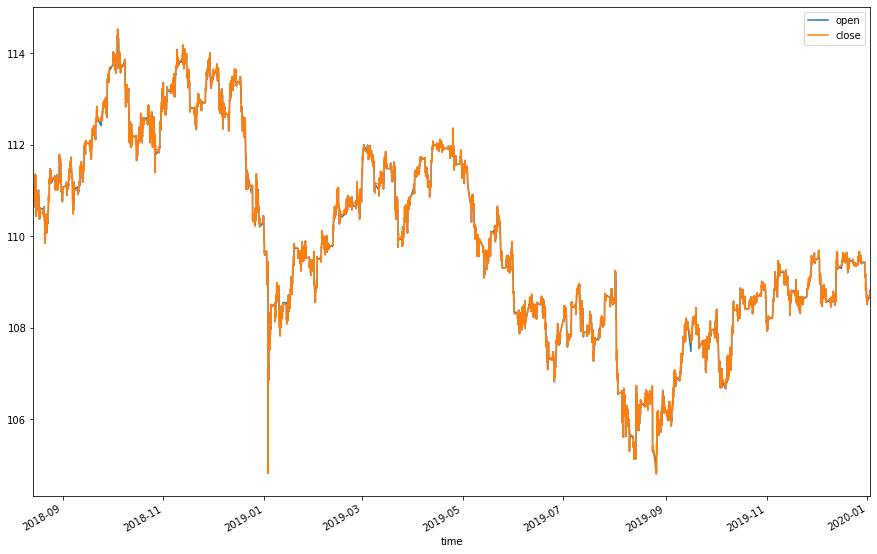

In [98]:
import pandas as pd
import numpy as np
%matplotlib inline

df = pd.read_csv('2018-08-14_06_00_00_2020-01-02_19_00_00_H1.csv', index_col='time', parse_dates=True)
df.drop(columns=['complete'],inplace=True)
df.plot(y=['open','close'],figsize=(15,10));

In [99]:
periods = 8619
df.index = pd.date_range(start='2018-08-14 06:00:00',freq='H',periods=periods)
df.index

DatetimeIndex(['2018-08-14 06:00:00', '2018-08-14 07:00:00',
               '2018-08-14 08:00:00', '2018-08-14 09:00:00',
               '2018-08-14 10:00:00', '2018-08-14 11:00:00',
               '2018-08-14 12:00:00', '2018-08-14 13:00:00',
               '2018-08-14 14:00:00', '2018-08-14 15:00:00',
               ...
               '2019-08-07 23:00:00', '2019-08-08 00:00:00',
               '2019-08-08 01:00:00', '2019-08-08 02:00:00',
               '2019-08-08 03:00:00', '2019-08-08 04:00:00',
               '2019-08-08 05:00:00', '2019-08-08 06:00:00',
               '2019-08-08 07:00:00', '2019-08-08 08:00:00'],
              dtype='datetime64[ns]', length=8619, freq='H')

In [100]:
# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [101]:
df = df[['open']]
df

,open
2018-08-14 06:00:00,110.687
2018-08-14 07:00:00,110.748
2018-08-14 08:00:00,110.722
2018-08-14 09:00:00,110.633
2018-08-14 10:00:00,110.790
...,...
2019-08-08 04:00:00,108.744
2019-08-08 05:00:00,108.710
2019-08-08 06:00:00,108.782
2019-08-08 07:00:00,108.783


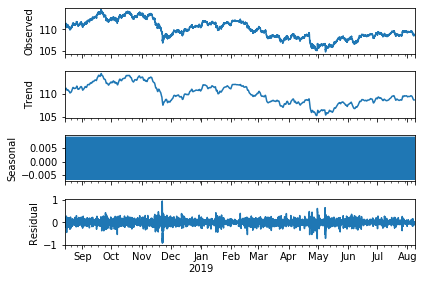

In [102]:
result = seasonal_decompose(df, model='add')
result.plot();

In [103]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df,seasonal=True,m=24).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 8619
Model:               SARIMAX(0, 1, 0)   Log Likelihood                9228.398
Date:                Sat, 01 Feb 2020   AIC                         -18454.797
Time:                        02:50:40   BIC                         -18447.735
Sample:                             0   HQIC                        -18452.389
                               - 8619                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0069   2.64e-05    260.022      0.000       0.007       0.007
===================================================================================
Ljung-Box (Q):                       53.10   Jarque-Bera (JB):            310516.04
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [104]:
len(df)

8619

In [105]:
import math
# Set one year for testing
train = df.iloc[:math.ceil(periods*0.8)]
test = df.iloc[math.ceil(periods*0.8):]
# train = df.iloc[:1440]
# test = df.iloc[1440:]

In [106]:
model = SARIMAX(train,order=(0,1,3),seasonal_order=(1,0,1,24))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               open   No. Observations:                 6896
Model:             SARIMAX(0, 1, 3)x(1, 0, 1, 24)   Log Likelihood                7063.913
Date:                            Sat, 01 Feb 2020   AIC                         -14115.826
Time:                                    02:50:42   BIC                         -14074.795
Sample:                                08-14-2018   HQIC                        -14101.677
                                     - 05-28-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0030      0.009     -0.355      0.723      -0.020       0.014
ma.L2         -0.0306      0.010     -3.205      0.001      -0.049      -0.012
ma.L3         -0.0094      0.011     -0.873      0.383      -0.030       0.012
ar.S.L24      -0.0820      1.085     -0.076      0.940      -2.208       2.044
ma.S.L24       0.0720      1.085      0.066      0.947      -2.055       2.199
sigma2         0.0075   3.74e-05    201.600      0.000       0.007       0.008
===================================================================================
Ljung-Box (Q):                       47.41   Jarque-Bera (JB):            257371.42
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [107]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,3)(1,0,1,24) Predictions')

In [108]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test.iloc[i]}")

predicted=107.9266774, expected=open    107.981
Name: 2019-05-28 14:00:00, dtype: float64
predicted=107.9270723, expected=open    107.883
Name: 2019-05-28 15:00:00, dtype: float64
predicted=107.9275922, expected=open    107.95
Name: 2019-05-28 16:00:00, dtype: float64
predicted=107.927984 , expected=open    107.882
Name: 2019-05-28 17:00:00, dtype: float64
predicted=107.9284786, expected=open    107.699
Name: 2019-05-28 18:00:00, dtype: float64
predicted=107.9279517, expected=open    107.658
Name: 2019-05-28 19:00:00, dtype: float64
predicted=107.9274649, expected=open    107.548
Name: 2019-05-28 20:00:00, dtype: float64
predicted=107.927558 , expected=open    107.554
Name: 2019-05-28 21:00:00, dtype: float64
predicted=107.9273745, expected=open    107.718
Name: 2019-05-28 22:00:00, dtype: float64
predicted=107.927557 , expected=open    107.722
Name: 2019-05-28 23:00:00, dtype: float64
predicted=107.9271078, expected=open    107.681
Name: 2019-05-29 00:00:00, dtype: float64
predicted=1

Name: 2019-06-11 04:00:00, dtype: float64
predicted=107.9281623, expected=open    107.472
Name: 2019-06-11 05:00:00, dtype: float64
predicted=107.9281623, expected=open    107.505
Name: 2019-06-11 06:00:00, dtype: float64
predicted=107.9281623, expected=open    107.512
Name: 2019-06-11 07:00:00, dtype: float64
predicted=107.9281623, expected=open    107.474
Name: 2019-06-11 08:00:00, dtype: float64
predicted=107.9281623, expected=open    107.41
Name: 2019-06-11 09:00:00, dtype: float64
predicted=107.9281623, expected=open    107.41
Name: 2019-06-11 10:00:00, dtype: float64
predicted=107.9281623, expected=open    107.392
Name: 2019-06-11 11:00:00, dtype: float64
predicted=107.9281623, expected=open    107.422
Name: 2019-06-11 12:00:00, dtype: float64
predicted=107.9281623, expected=open    107.456
Name: 2019-06-11 13:00:00, dtype: float64
predicted=107.9281623, expected=open    107.622
Name: 2019-06-11 14:00:00, dtype: float64
predicted=107.9281623, expected=open    107.856
Name: 2019-0

Name: 2019-06-20 09:00:00, dtype: float64
predicted=107.9281623, expected=open    108.386
Name: 2019-06-20 10:00:00, dtype: float64
predicted=107.9281623, expected=open    108.472
Name: 2019-06-20 11:00:00, dtype: float64
predicted=107.9281623, expected=open    108.458
Name: 2019-06-20 12:00:00, dtype: float64
predicted=107.9281623, expected=open    108.526
Name: 2019-06-20 13:00:00, dtype: float64
predicted=107.9281623, expected=open    108.582
Name: 2019-06-20 14:00:00, dtype: float64
predicted=107.9281623, expected=open    108.62
Name: 2019-06-20 15:00:00, dtype: float64
predicted=107.9281623, expected=open    108.64
Name: 2019-06-20 16:00:00, dtype: float64
predicted=107.9281623, expected=open    108.688
Name: 2019-06-20 17:00:00, dtype: float64
predicted=107.9281623, expected=open    108.669
Name: 2019-06-20 18:00:00, dtype: float64
predicted=107.9281623, expected=open    108.655
Name: 2019-06-20 19:00:00, dtype: float64
predicted=107.9281623, expected=open    108.682
Name: 2019-0

predicted=107.9281623, expected=open    109.04
Name: 2019-07-05 02:00:00, dtype: float64
predicted=107.9281623, expected=open    109.041
Name: 2019-07-05 03:00:00, dtype: float64
predicted=107.9281623, expected=open    109.058
Name: 2019-07-05 04:00:00, dtype: float64
predicted=107.9281623, expected=open    109.09
Name: 2019-07-05 05:00:00, dtype: float64
predicted=107.9281623, expected=open    109.073
Name: 2019-07-05 06:00:00, dtype: float64
predicted=107.9281623, expected=open    109.062
Name: 2019-07-05 07:00:00, dtype: float64
predicted=107.9281623, expected=open    109.126
Name: 2019-07-05 08:00:00, dtype: float64
predicted=107.9281623, expected=open    108.901
Name: 2019-07-05 09:00:00, dtype: float64
predicted=107.9281623, expected=open    108.94
Name: 2019-07-05 10:00:00, dtype: float64
predicted=107.9281623, expected=open    108.928
Name: 2019-07-05 11:00:00, dtype: float64
predicted=107.9281623, expected=open    108.84
Name: 2019-07-05 12:00:00, dtype: float64
predicted=107.

Name: 2019-07-19 06:00:00, dtype: float64
predicted=107.9281623, expected=open    109.093
Name: 2019-07-19 07:00:00, dtype: float64
predicted=107.9281623, expected=open    109.101
Name: 2019-07-19 08:00:00, dtype: float64
predicted=107.9281623, expected=open    109.029
Name: 2019-07-19 09:00:00, dtype: float64
predicted=107.9281623, expected=open    108.856
Name: 2019-07-19 10:00:00, dtype: float64
predicted=107.9281623, expected=open    108.844
Name: 2019-07-19 11:00:00, dtype: float64
predicted=107.9281623, expected=open    108.766
Name: 2019-07-19 12:00:00, dtype: float64
predicted=107.9281623, expected=open    108.72
Name: 2019-07-19 13:00:00, dtype: float64
predicted=107.9281623, expected=open    108.683
Name: 2019-07-19 14:00:00, dtype: float64
predicted=107.9281623, expected=open    108.548
Name: 2019-07-19 15:00:00, dtype: float64
predicted=107.9281623, expected=open    108.526
Name: 2019-07-19 16:00:00, dtype: float64
predicted=107.9281623, expected=open    108.531
Name: 2019-

Name: 2019-07-30 17:00:00, dtype: float64
predicted=107.9281623, expected=open    109.59
Name: 2019-07-30 18:00:00, dtype: float64
predicted=107.9281623, expected=open    109.567
Name: 2019-07-30 19:00:00, dtype: float64
predicted=107.9281623, expected=open    109.576
Name: 2019-07-30 20:00:00, dtype: float64
predicted=107.9281623, expected=open    109.578
Name: 2019-07-30 21:00:00, dtype: float64
predicted=107.9281623, expected=open    109.554
Name: 2019-07-30 22:00:00, dtype: float64
predicted=107.9281623, expected=open    109.654
Name: 2019-07-30 23:00:00, dtype: float64
predicted=107.9281623, expected=open    109.577
Name: 2019-07-31 00:00:00, dtype: float64
predicted=107.9281623, expected=open    109.576
Name: 2019-07-31 01:00:00, dtype: float64
predicted=107.9281623, expected=open    109.577
Name: 2019-07-31 02:00:00, dtype: float64
predicted=107.9281623, expected=open    109.592
Name: 2019-07-31 03:00:00, dtype: float64
predicted=107.9281623, expected=open    109.591
Name: 2019-

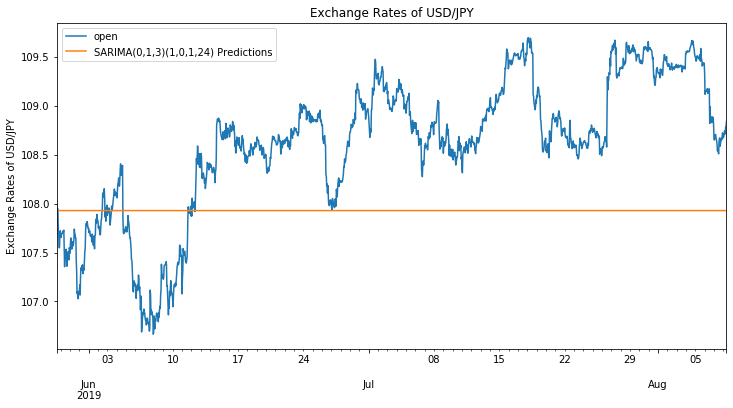

In [109]:
# Plot predictions against known values
title = 'Exchange Rates of USD/JPY'
ylabel='Exchange Rates of USD/JPY'
xlabel=''

ax = test.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [110]:
test.mean()

open    108.60693
dtype: float64

In [111]:
predictions.mean()

107.92815932740508

In [112]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions)
print(f'SARIMA(0,1,3)(1,0,1,24) MSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,24) MSE Error: 0.9486659446


In [113]:
from statsmodels.tools.eval_measures import rmse

error = np.sqrt(mean_squared_error(test, predictions))
print(f'SARIMA(0,1,3)(1,0,1,24) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,24) RMSE Error: 0.9739948381


In [114]:
model = SARIMAX(df,order=(0,1,3),seasonal_order=(1,0,1,24))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               open   No. Observations:                 8619
Model:             SARIMAX(0, 1, 3)x(1, 0, 1, 24)   Log Likelihood                9231.135
Date:                            Sat, 01 Feb 2020   AIC                         -18450.271
Time:                                    02:50:48   BIC                         -18407.901
Sample:                                08-14-2018   HQIC                        -18435.822
                                     - 08-08-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0062      0.007     -0.832      0.405      -0.021       0.008
ma.L2         -0.0233      0.008     -2.822      0.005      -0.040      -0.007
ma.L3         -0.0040      0.009     -0.429      0.668      -0.022       0.014
ar.S.L24      -0.0748      1.922     -0.039      0.969      -3.843       3.693
ma.S.L24       0.0701      1.923      0.036      0.971      -3.699       3.839
sigma2         0.0069   3.03e-05    226.721      0.000       0.007       0.007
===================================================================================
Ljung-Box (Q):                       47.79   Jarque-Bera (JB):            315097.98
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [115]:
start=len(df)
end=len(df) + math.ceil(periods*0.2)
fcast = results.predict(start=start,end=end,dynamic=False,typ='levels').rename('SARIMA(0,1,3)(1,0,1,24) Forecast')

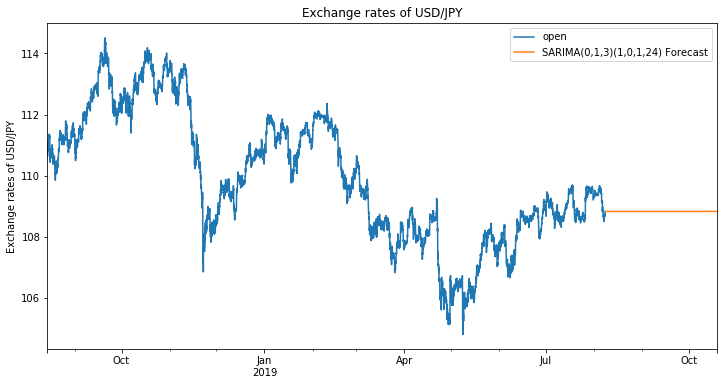

In [116]:
# Plot predictions against known values
title = 'Exchange rates of USD/JPY'
ylabel='Exchange rates of USD/JPY'
xlabel=''

ax = df.plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [117]:
df

,open
2018-08-14 06:00:00,110.687
2018-08-14 07:00:00,110.748
2018-08-14 08:00:00,110.722
2018-08-14 09:00:00,110.633
2018-08-14 10:00:00,110.790
...,...
2019-08-08 04:00:00,108.744
2019-08-08 05:00:00,108.710
2019-08-08 06:00:00,108.782
2019-08-08 07:00:00,108.783
